# Libs

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Model, load_model, model_from_json
from keras.layers import Dense, Dropout, Activation, Flatten, Normalization
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Reshape
from keras.regularizers import l2
from keras.utils import to_categorical
from sklearn.metrics import confusion_matrix
from keras.preprocessing import image
from sklearn.metrics import f1_score
import cv2

# Read dataset

Data are get from [link](https://drive.google.com/file/d/18yZyj5qqg8-UHlheqmCMM4wf9KOdV42T/view)

In [2]:
df = pd.read_csv('./data/fer2013.csv')
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 35887 entries, 0 to 35886
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  35887 non-null  int64 
 1   pixels   35887 non-null  object
 2   Usage    35887 non-null  object
dtypes: int64(1), object(2)
memory usage: 841.2+ KB
None


In [4]:
df['pixels'] = df['pixels'].str.split(' ')
df.head()

,emotion,pixels,Usage
0,0,"[70, 80, 82, 72, 58, 58, 60, 63, 54, 58, 60, 4...",Training
1,0,"[151, 150, 147, 155, 148, 133, 111, 140, 170, ...",Training
2,2,"[231, 212, 156, 164, 174, 138, 161, 173, 182, ...",Training
3,4,"[24, 32, 36, 30, 32, 23, 19, 20, 30, 41, 21, 2...",Training
4,6,"[4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 15, 23...",Training


In [5]:
class Dataset:
    def __init__(self, df):
        train = df[df['Usage'] == 'Training']
        val = df[df['Usage'] == 'PublicTest']
        test = df[df['Usage'] == 'PrivateTest']

        self.train_x, self.train_y = np.vstack(train['pixels']).astype('float'), train['emotion']
        self.val_x, self.val_y = np.vstack(val['pixels']).astype('float'), val['emotion']
        self.test_x, self.test_y = np.vstack(test['pixels']).astype('float'), test['emotion']

        self.num_labels = len(df['emotion'].unique())
        self.width, self.height = 48, 48

        self.train_y_onehot = to_categorical(self.train_y, num_classes=self.num_labels)
        self.val_y_onehot = to_categorical(self.val_y, num_classes=self.num_labels)
        self.test_y_onehot = to_categorical(self.test_y, num_classes=self.num_labels)

    def normalization(self):
        self.normalization_layer = Normalization()
        self.normalization_layer.adapt(self.train_x)

        self.normalized_train_x = self.normalization_layer(self.train_x)
        self.normalized_val_x = self.normalization_layer(self.val_x)
        self.normalized_test_x = self.normalization_layer(self.test_x)
        
dataset = Dataset(df)
dataset.normalization()

# Build model

In [6]:
class CNN(Model):
    def __init__(self, dataset):
        super(CNN, self).__init__()
        self.reshape = Reshape((dataset.height, dataset.width, 1)) # Reshaping flattened input
        
        # 1st Convolution Layer
        self.conv1 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.conv2 = Conv2D(64, kernel_size=(3, 3), activation='relu')
        self.pool1 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.drop1 = Dropout(0.5)
        
        # 2nd Convolution Layer
        self.conv3 = Conv2D(64, (3, 3), activation='relu')
        self.conv4 = Conv2D(64, (3, 3), activation='relu')
        self.pool2 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))
        self.drop2 = Dropout(0.5)

        # 3rd Convolution Layer (adjusted to control spatial size reduction)
        self.conv5 = Conv2D(128, (3, 3), activation='relu')
        self.conv6 = Conv2D(128, (3, 3), activation='relu')
        self.pool3 = MaxPooling2D(pool_size=(2, 2), strides=(2, 2))  # Final pooling layer

        # Flatten and fully connected layers
        self.flatten = Flatten()
        self.fc1 = Dense(1024, activation='relu')
        self.drop3 = Dropout(0.2)
        self.fc2 = Dense(1024, activation='relu')
        self.drop4 = Dropout(0.2)
        self.output_layer = Dense(dataset.num_labels, activation='softmax')

    def call(self, inputs):
        x = self.reshape(inputs)
        
        # 1st Convolution Layer
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pool1(x)
        x = self.drop1(x)
        
        # 2nd Convolution Layer
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pool2(x)
        x = self.drop2(x)

        # 3rd Convolution Layer (adjusted pool size)
        x = self.conv5(x)
        x = self.conv6(x)
        x = self.pool3(x)

        # Flatten and fully connected layers
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.drop3(x)
        x = self.fc2(x)
        x = self.drop4(x)

        return self.output_layer(x)

model = CNN(dataset)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
history = model.fit(dataset.normalized_train_x, dataset.train_y_onehot, epochs=1, batch_size=1, validation_data=(dataset.normalized_val_x, dataset.val_y_onehot), shuffle=True)

# Inference

In [7]:
def predict_img(x, model=model, size=(dataset.height, dataset.width), verbose=False):
    if verbose:
        x = cv2.resize(x, (dataset.height, dataset.width))
        plt.figure(figsize=(4, 3))
        plt.imshow(x)
        plt.show()
    x /= 255
    x = x.reshape(-1, size[0]*size[1])
    pred_prob = model.predict(x, verbose=0)
    return pred_prob, np.argmax(pred_prob, axis=1)

def predict_from_path(path, model=model, size=(dataset.height, dataset.width), verbose=False):
    img = image.load_img(path, color_mode='grayscale', target_size=size)
    x = image.img_to_array(img)
    return predict_img(x, model, dataset, verbose)

In [35]:
predict_img(dataset.train_x[0:2,:])

(array([[0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
         0.14285715, 0.14285715],
        [0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
         0.14285715, 0.14285715]], dtype=float32),
 array([0, 0], dtype=int64))

# Save model

In [ ]:
# fer_json = model.to_json()
# with open("fer.json", "w") as json_file:
#     json_file.write(fer_json)
# model.save_weights("fer.h5")

In [ ]:
# model = model_from_json(open("fer.json", "r").read())
# model.load_weights('fer.h5')

In [9]:
# model.save('models/cnn.keras')
# model = load_model('models/cnn.keras')

# Evaluate model

In [29]:
train_score = model.evaluate(dataset.train_x, dataset.train_y_onehot, verbose=0)
print('Train loss:', train_score[0])
print('Train accuracy:', 100*train_score[1])

y_pred_classes = predict_img(dataset.train_x)[1]
print('Train f1-score:', f1_score(dataset.train_y, y_pred_classes, average='weighted'))

test_score = model.evaluate(dataset.test_x, dataset.test_y_onehot, verbose=0)
print('Test loss:', test_score[0])
print('Test accuracy:', 100*test_score[1])

y_pred_classes = predict_img(dataset.test_x)[1]
print('Test f1-score:', f1_score(dataset.test_y, y_pred_classes, average='weighted'))

Train loss: 1.945920705795288
Train accuracy: 13.915497064590454
Train f1-score: 0.03399731534101657
Test loss: 1.9439390897750854
Test accuracy: 15.24101346731186
Test f1-score: 0.07141929690680301


# Confusion Matrix

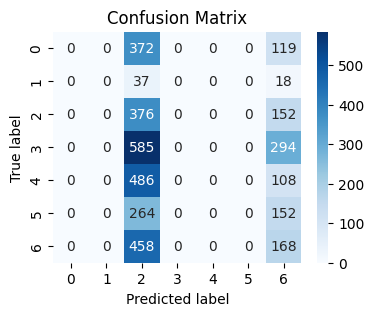

In [31]:
cm = confusion_matrix(dataset.test_y, y_pred_classes)
plt.figure(figsize=(4, 3))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Testing

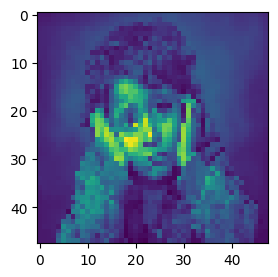

array([[0.14200468, 0.14092997, 0.14476638, 0.1424804 , 0.14240293,
        0.14379025, 0.14362541]], dtype=float32)

In [41]:
path = 'data/sad.jpg'
custom = predict_from_path(path, verbose=True)[0]
custom

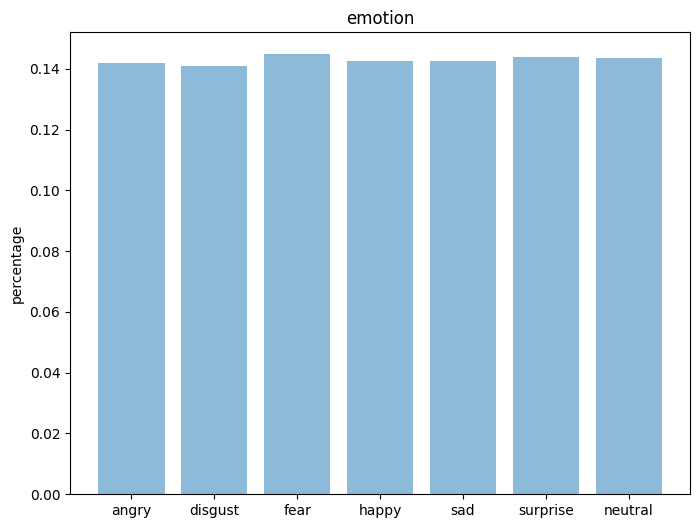

In [44]:
def emotion_analysis(emotions):
    objects = ('angry', 'disgust', 'fear', 'happy', 'sad', 'surprise', 'neutral')
    y_pos = np.arange(len(objects))
    plt.figure(figsize=(8, 6))
    plt.bar(y_pos, emotions, align='center', alpha=0.5)
    plt.xticks(y_pos, objects)
    plt.ylabel('percentage')
    plt.title('emotion')
    plt.show()
    
emotion_analysis(custom[0])

# Detecting Real-Time Emotion

In [5]:
!py real-time_reg.py

2024-09-22 13:10:03.968779: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 13:10:05.796689: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-22 13:10:09.097786: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Infernce

[Building a Real Time Emotion Detection with Python](https://medium.com/@Coursesteach/building-a-real-time-emotion-detection-with-python-7fe6090a125d)